In [1]:
%matplotlib notebook
import numpy as np
import pickle
from glob import glob
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
from scipy.optimize import minimize

from donutlib.donututil import getZemaxWfm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def postotheta(xpos,ypos,degpermm=0.0048891,a7=-0.0021,a9=-0.0021):
    
# convert xpos,ypos to xtheta,ytheta
#
# F/# = 2.922 and Focal Length = 11719.07mm
# so Plate Scale = 206265/flength = 17.601 arcsec/mm
#
# 17.601 arcsec/mm / 3600 arcsec/deg = 0.0048891 deg/mm
#
# a7 and a9 are in units of deg/(deg^3)
#    degpermm = 0.0048891
#    a7 = -0.0021
#    a9 = -0.0021

    xpt = xpos*degpermm
    ypt = ypos*degpermm

    xtheta = xpt + a7 * xpt*xpt*xpt + a9 * xpt*ypt*ypt
    ytheta = ypt + a7 * ypt*ypt*ypt + a9 * ypt*xpt*xpt

    return xtheta,ytheta

In [3]:
outdict_wide = pickle.load(open("/Users/roodman/Astrophysics/Zemax/Decam/ZernikeMaps/decam-2012/Zernike_coefs_map-nominal-wide-1.5mmextrafocal.pickle",'rb'),encoding='iso-8859-1')

In [4]:
outdict_wide.keys()

dict_keys([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 3

In [5]:
nw = len(outdict_wide)
print(nw)
x_fpw = np.zeros((nw))
y_fpw = np.zeros((nw))
x_thetaw = np.zeros((nw))
y_thetaw = np.zeros((nw))
zern_fpw = np.zeros((nw,37))

i = 0
for key in outdict_wide:

    x_thetaw[i],y_thetaw[i],x_fpw[i],y_fpw[i],zern_coeffw = outdict_wide[key]
    for iz in range(37):
        zern_fpw[i,:] = zern_coeffw
    i = i + 1



1649


<IPython.core.display.Javascript object>


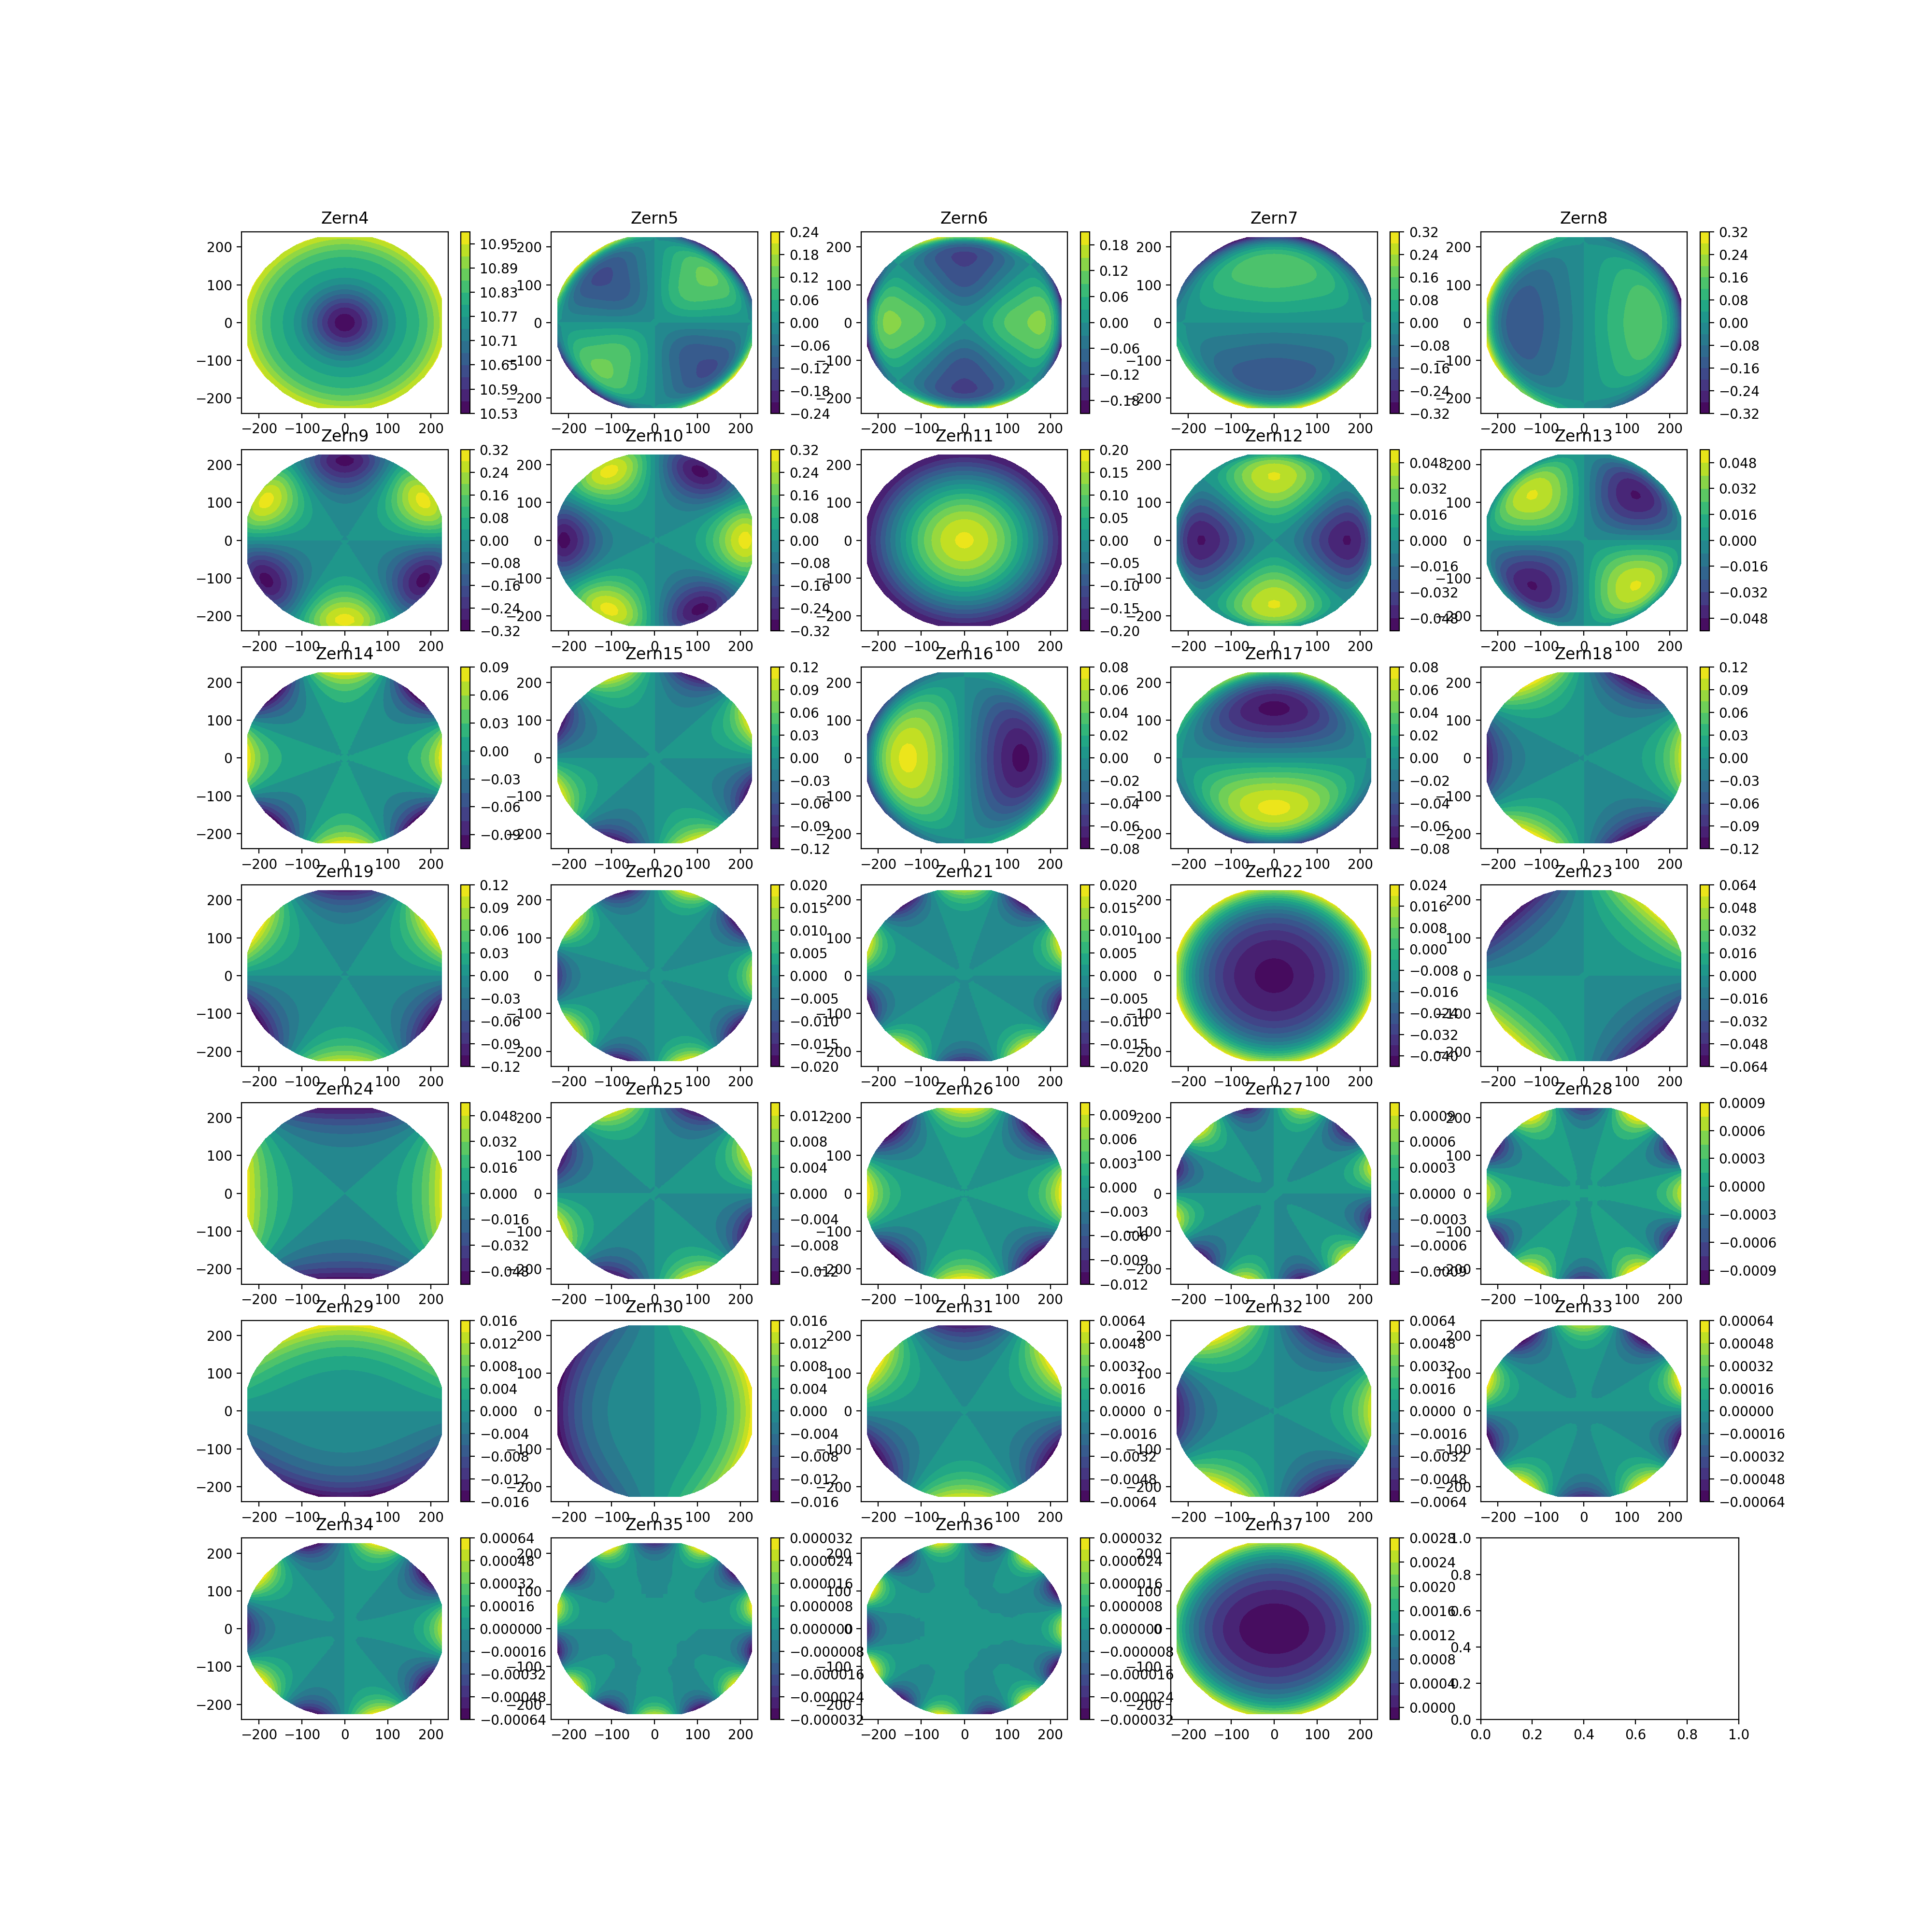

In [6]:
f,ax = plt.subplots(7,5,figsize=(20,20))
axf = ax.flatten()
aplots = []

for iz in range(3,37):
    aplot = axf[iz-3].tricontourf(x_fpw, y_fpw, zern_fpw[:,iz], 15)
    axf[iz-3].set_xlim(-240,240)
    axf[iz-3].set_ylim(-240,240)
    f.colorbar(aplot,ax=axf[iz-3])
    axf[iz-3].set_title("Zern%d" % (iz+1))

<IPython.core.display.Javascript object>


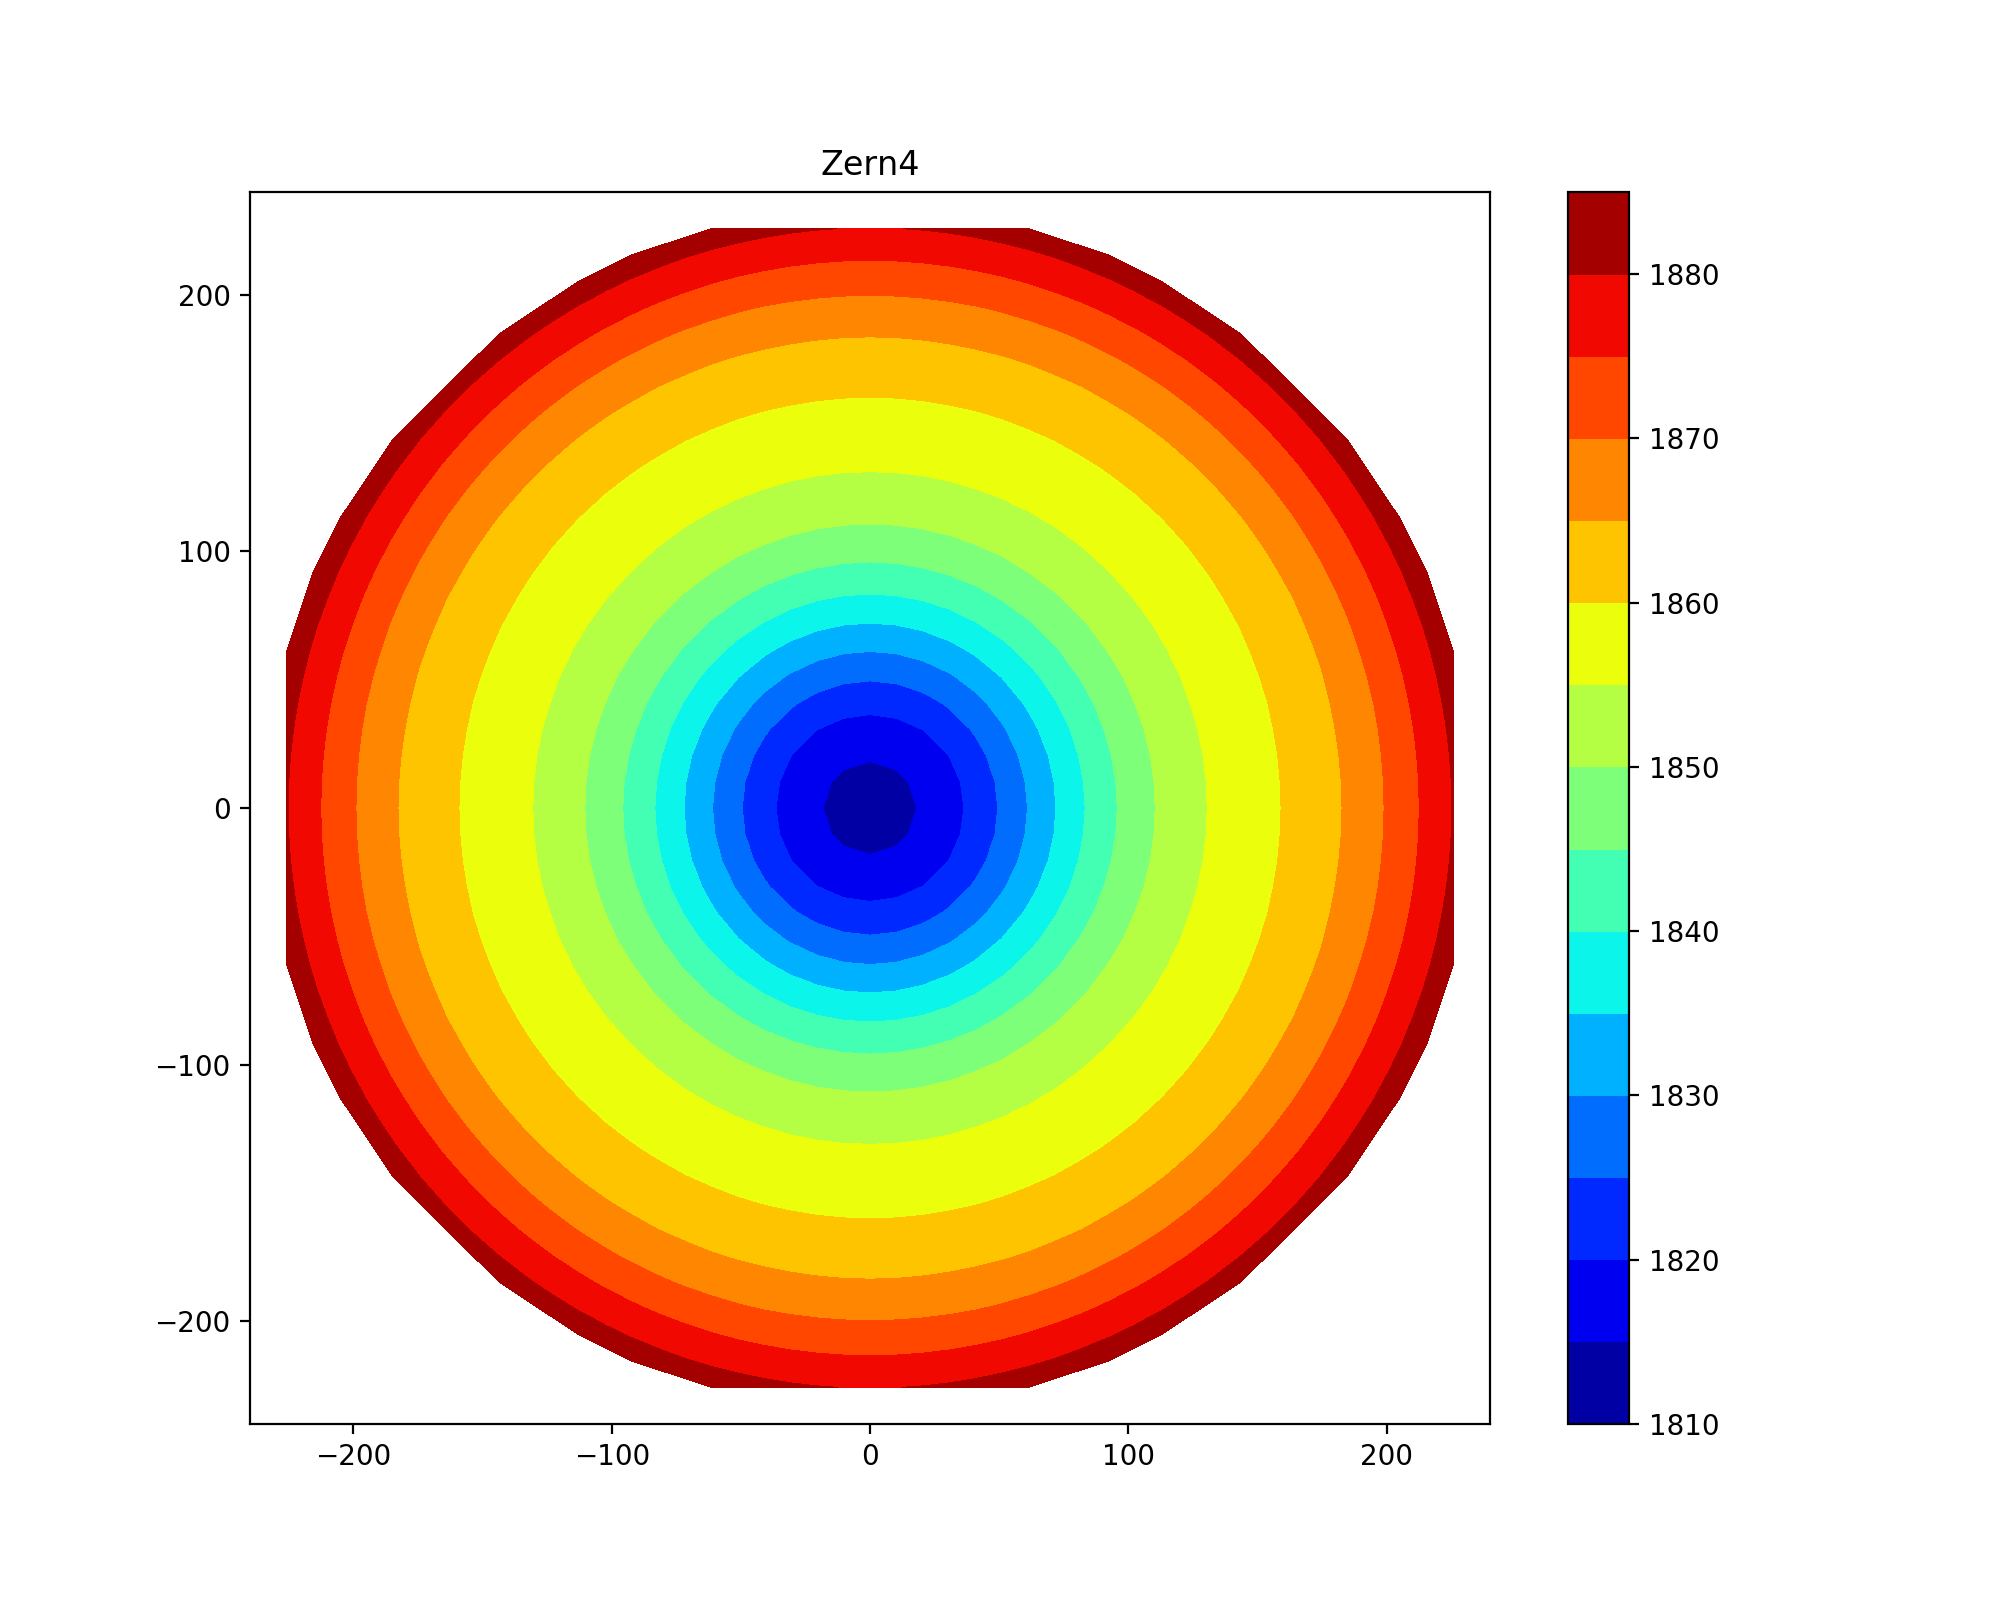

Text(0.5, 1.0, 'Zern4')

In [7]:
from matplotlib import cm

# plots with different color scheme
f,ax = plt.subplots(1,1,figsize=(10,8))

iz = 3
aplot = ax.tricontourf(x_fpw, y_fpw, zern_fpw[:,iz]*172.,15,cmap=cm.jet)
ax.set_xlim(-240,240)
ax.set_ylim(-240,240)
f.colorbar(aplot,ax=ax)
ax.set_title("Zern%d" % (iz+1))

<IPython.core.display.Javascript object>


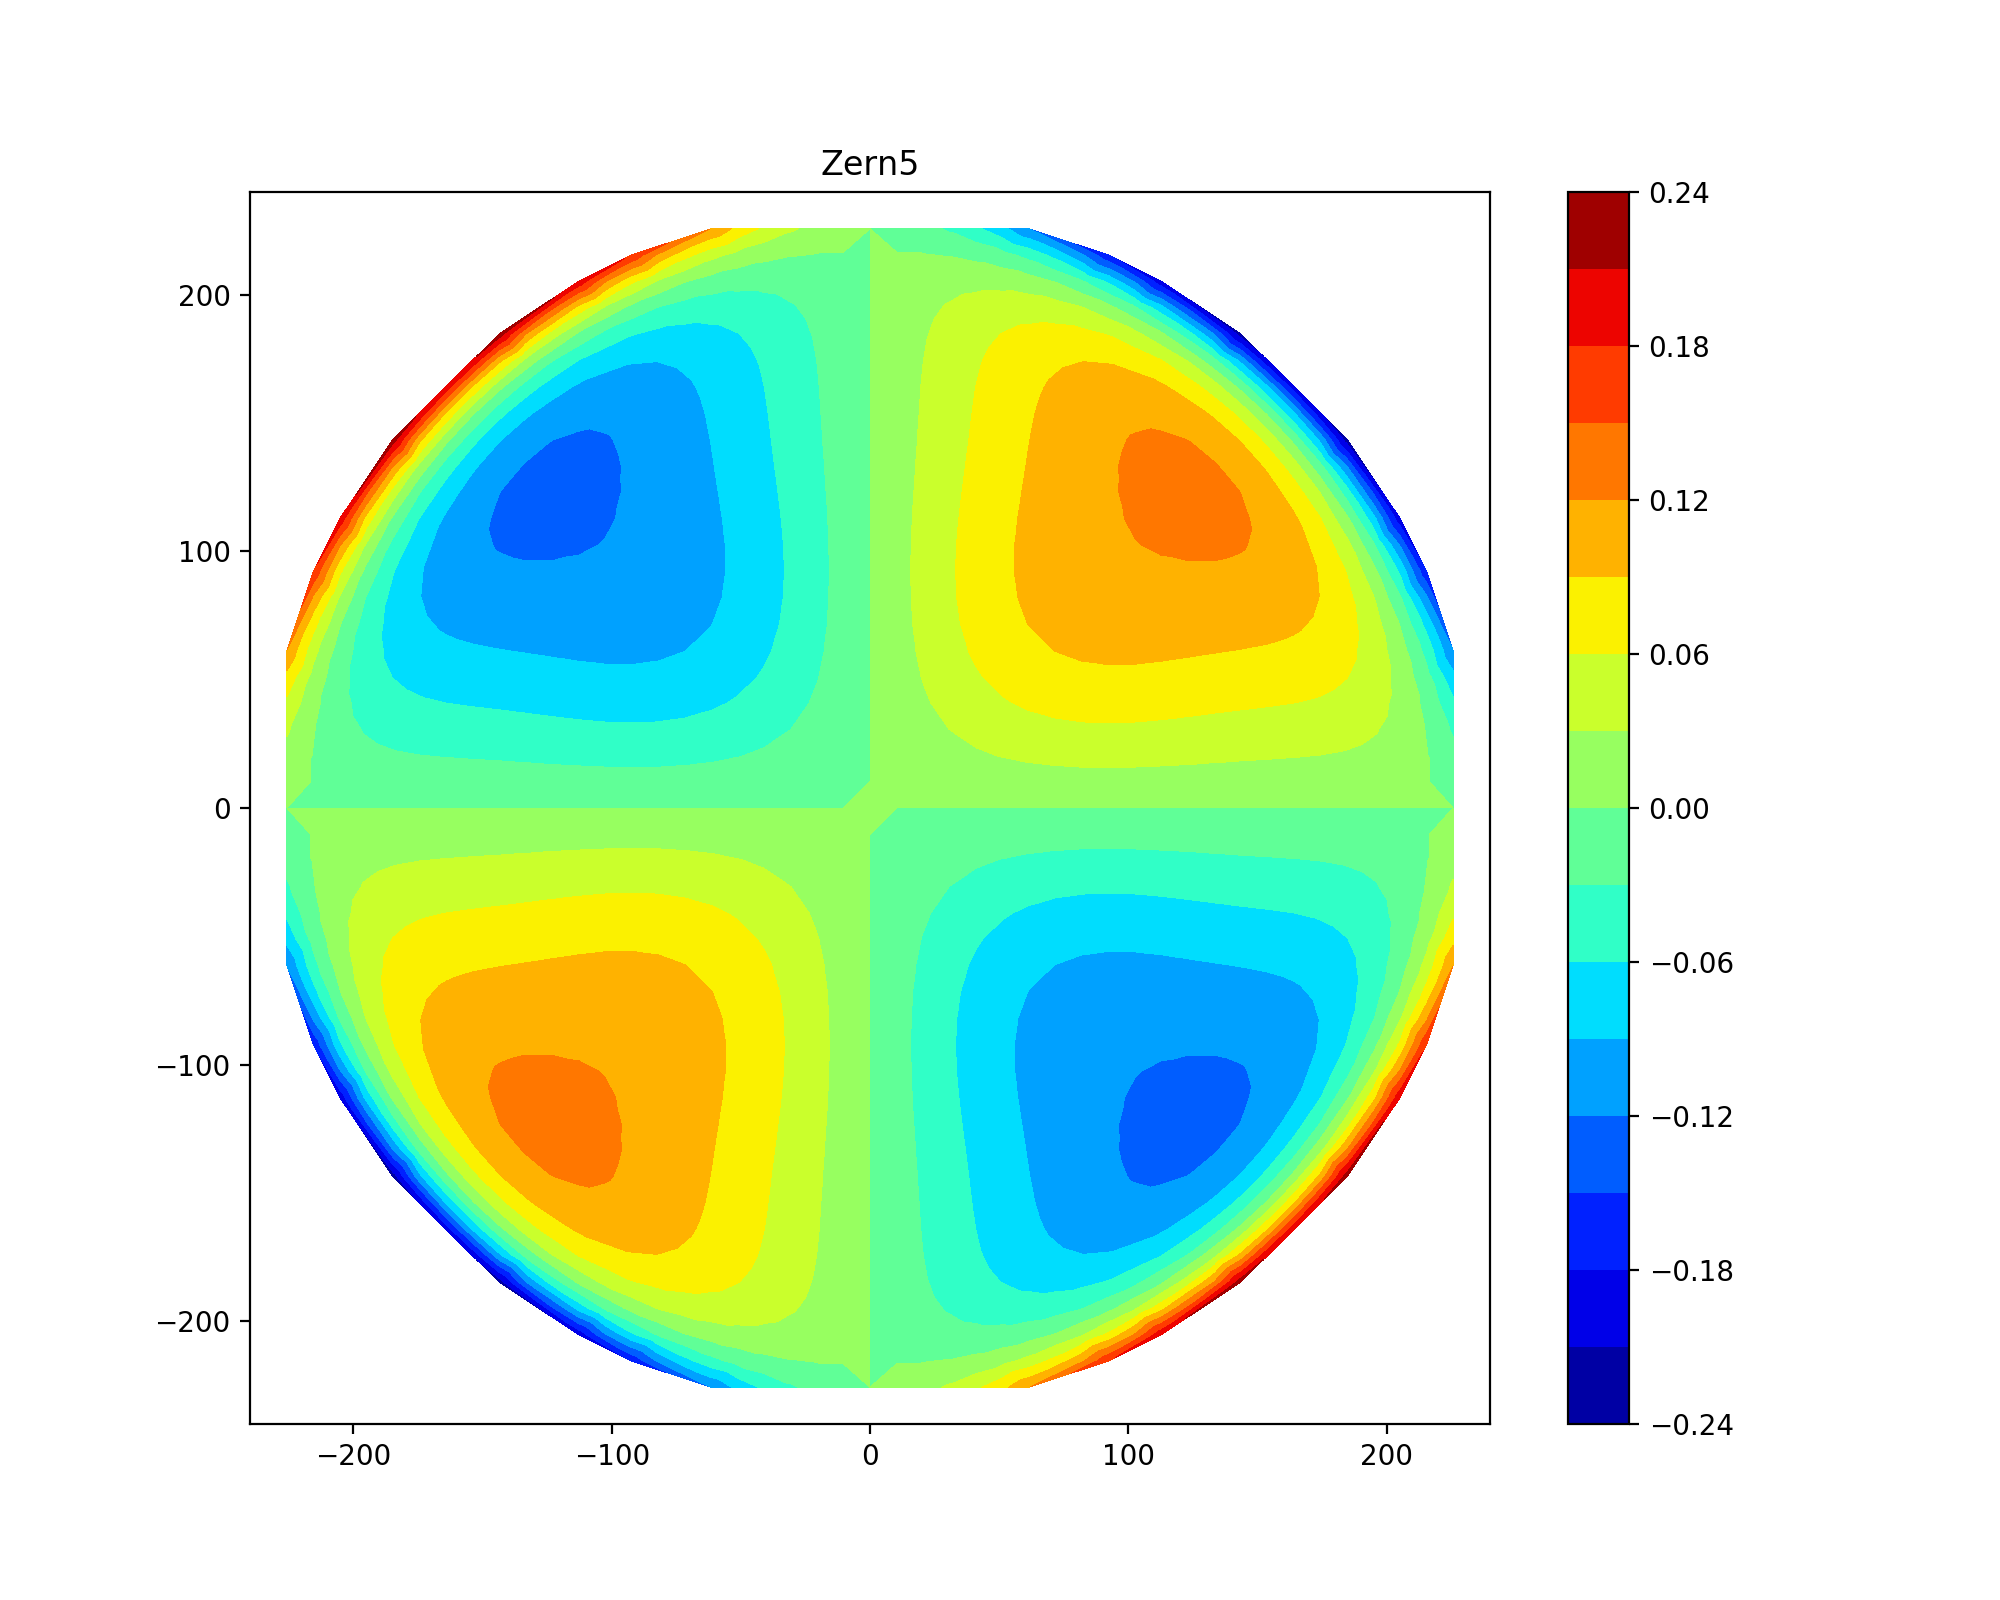

Text(0.5, 1.0, 'Zern5')

In [8]:
# plots with different color scheme
f,ax = plt.subplots(1,1,figsize=(10,8))

iz = 4
aplot = ax.tricontourf(x_fpw, y_fpw, zern_fpw[:,iz],15,cmap=cm.jet)
ax.set_xlim(-240,240)
ax.set_ylim(-240,240)
f.colorbar(aplot,ax=ax)
ax.set_title("Zern%d" % (iz+1))

<IPython.core.display.Javascript object>


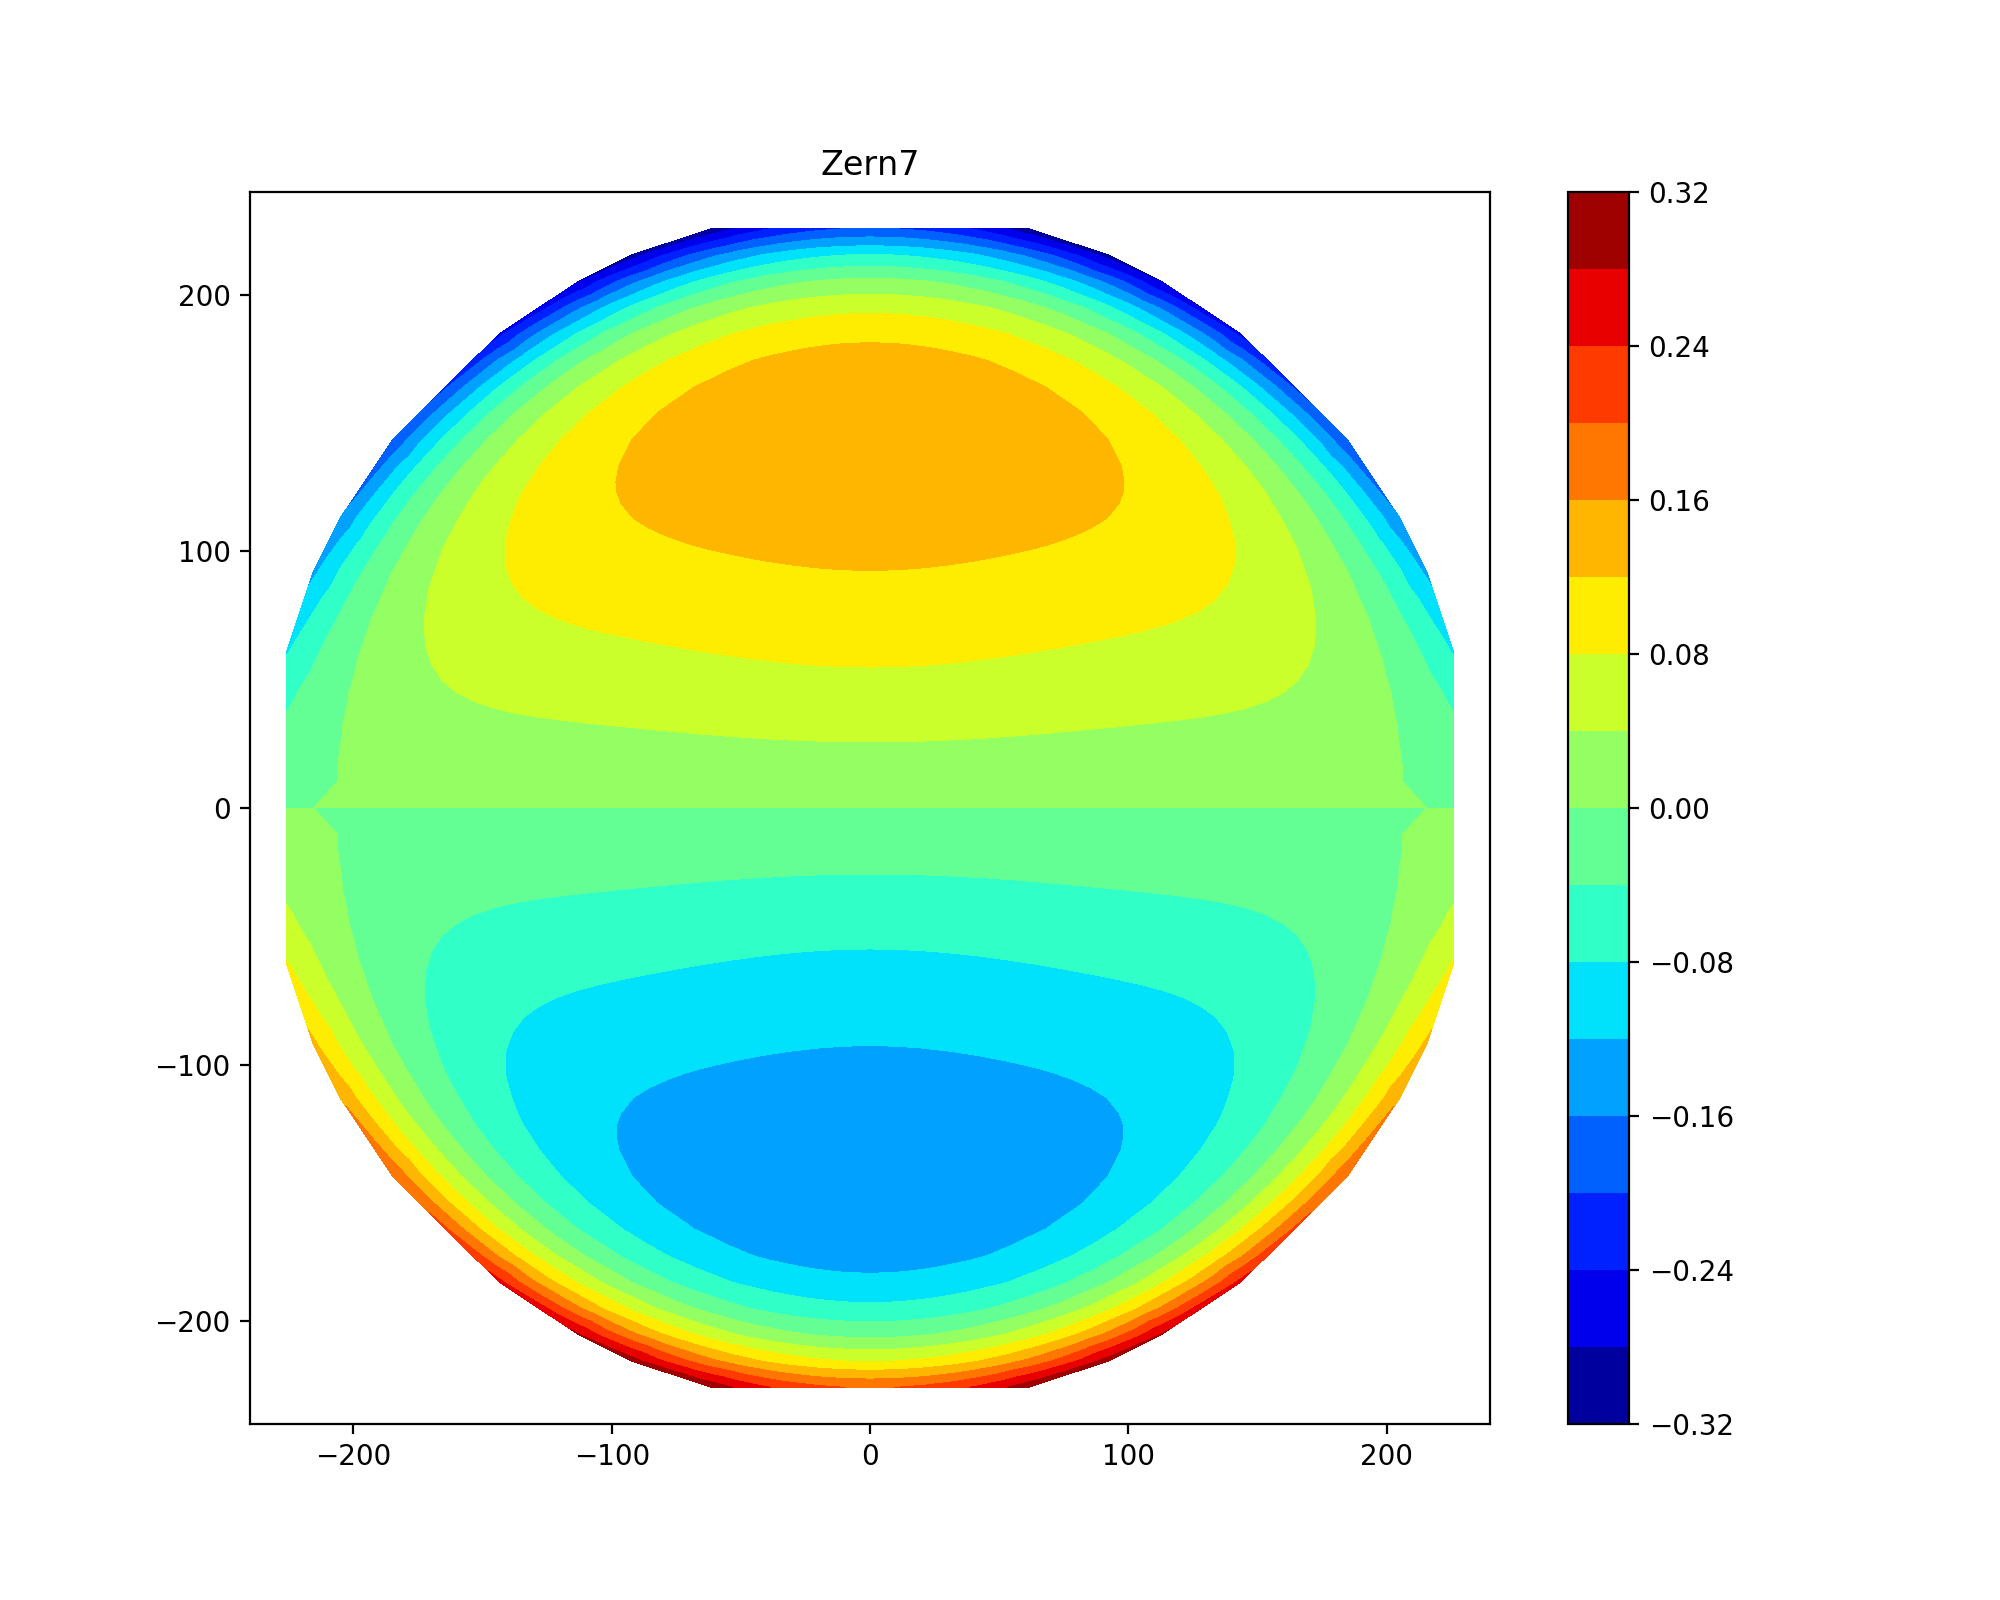

Text(0.5, 1.0, 'Zern7')

In [9]:
# plots with different color scheme
f,ax = plt.subplots(1,1,figsize=(10,8))

iz = 6
aplot = ax.tricontourf(x_fpw, y_fpw, zern_fpw[:,iz],15,cmap=cm.jet)
ax.set_xlim(-240,240)
ax.set_ylim(-240,240)
f.colorbar(aplot,ax=ax)
ax.set_title("Zern%d" % (iz+1))

In [10]:
# Interpolation for Zernike coefficients
from scipy.interpolate import SmoothBivariateSpline
from scipy.interpolate import Rbf

In [11]:
dictOfInterps = {}
for iZ in range(3,37):
    dictOfInterps[iZ] = Rbf(x_fpw, y_fpw, zern_fpw[:,iZ])

<IPython.core.display.Javascript object>


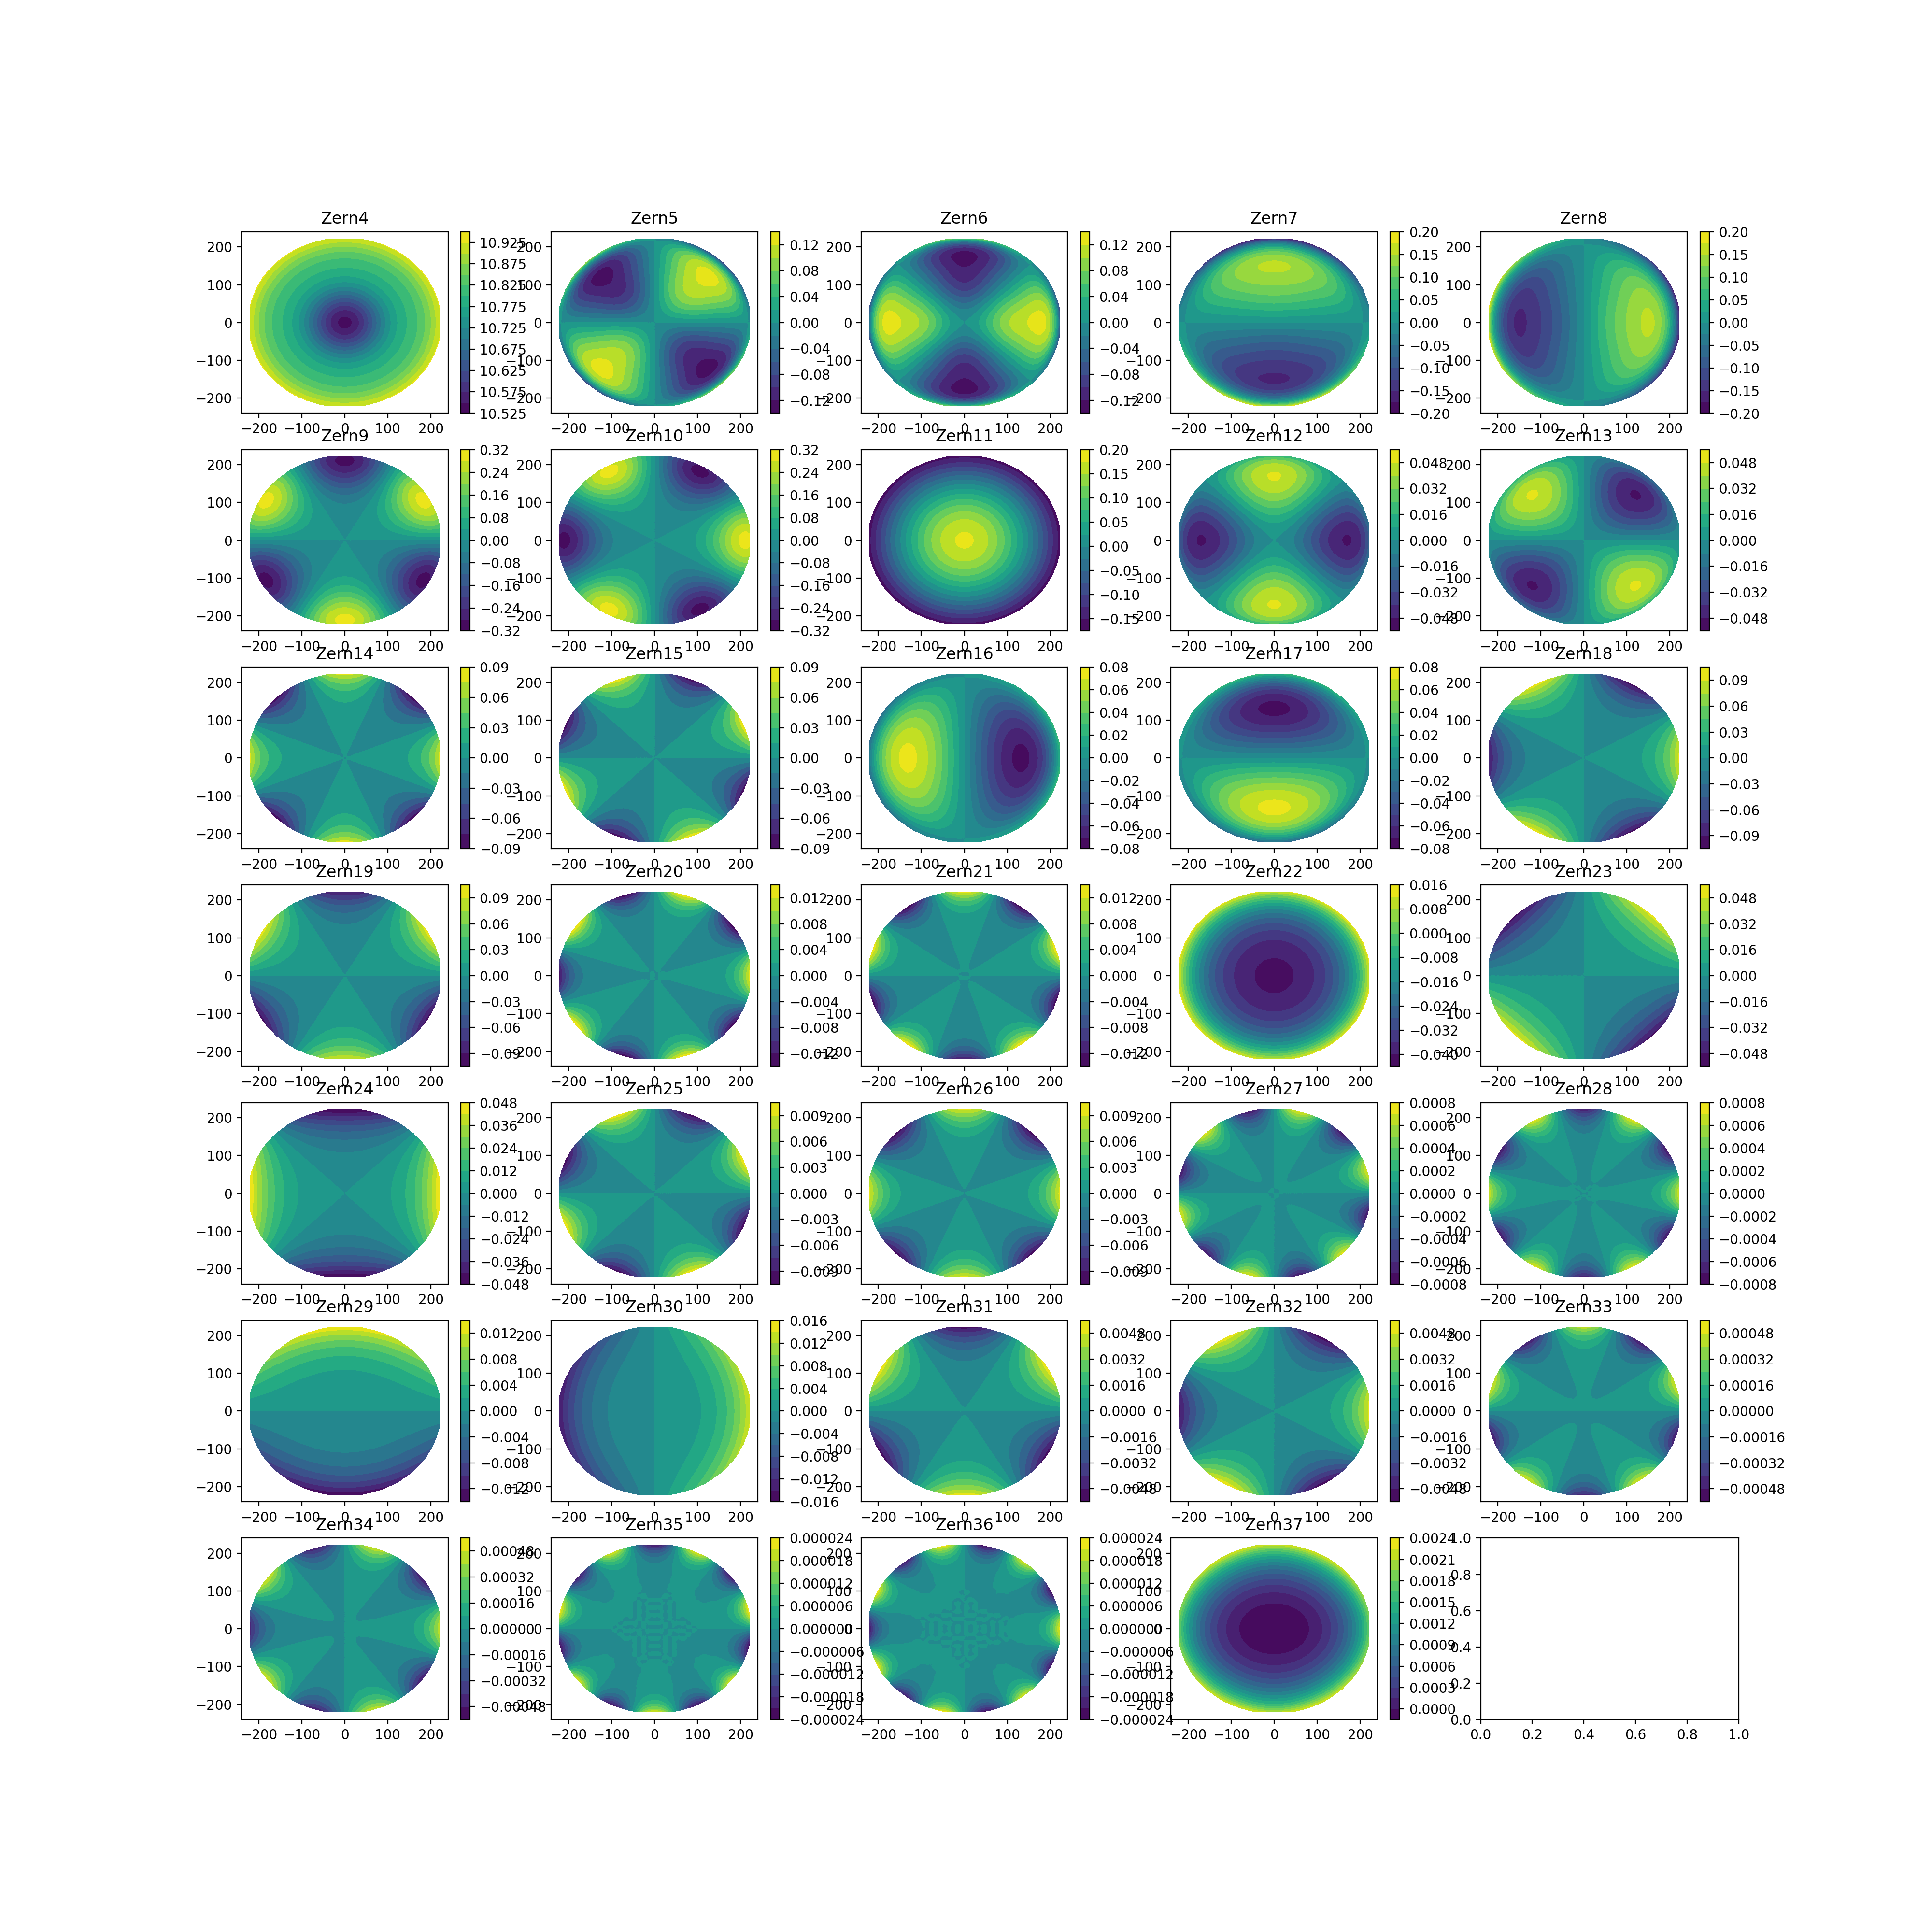

In [12]:
f,ax = plt.subplots(7,5,figsize=(20,20))
axf = ax.flatten()
aplots = []

yin, xin = np.mgrid[-235.:235.:100j,-235.:235.:100j]
rin = np.sqrt(xin*xin+yin*yin)
ok = rin<=225.
xgood = xin[ok]
ygood = yin[ok]

for iz in range(3,37):
    zern_interp = dictOfInterps[iz](xgood,ygood)
    aplot = axf[iz-3].tricontourf(xgood, ygood, zern_interp, 15)
    axf[iz-3].set_xlim(-240,240)
    axf[iz-3].set_ylim(-240,240)
    f.colorbar(aplot,ax=axf[iz-3])
    axf[iz-3].set_title("Zern%d" % (iz+1))

<IPython.core.display.Javascript object>


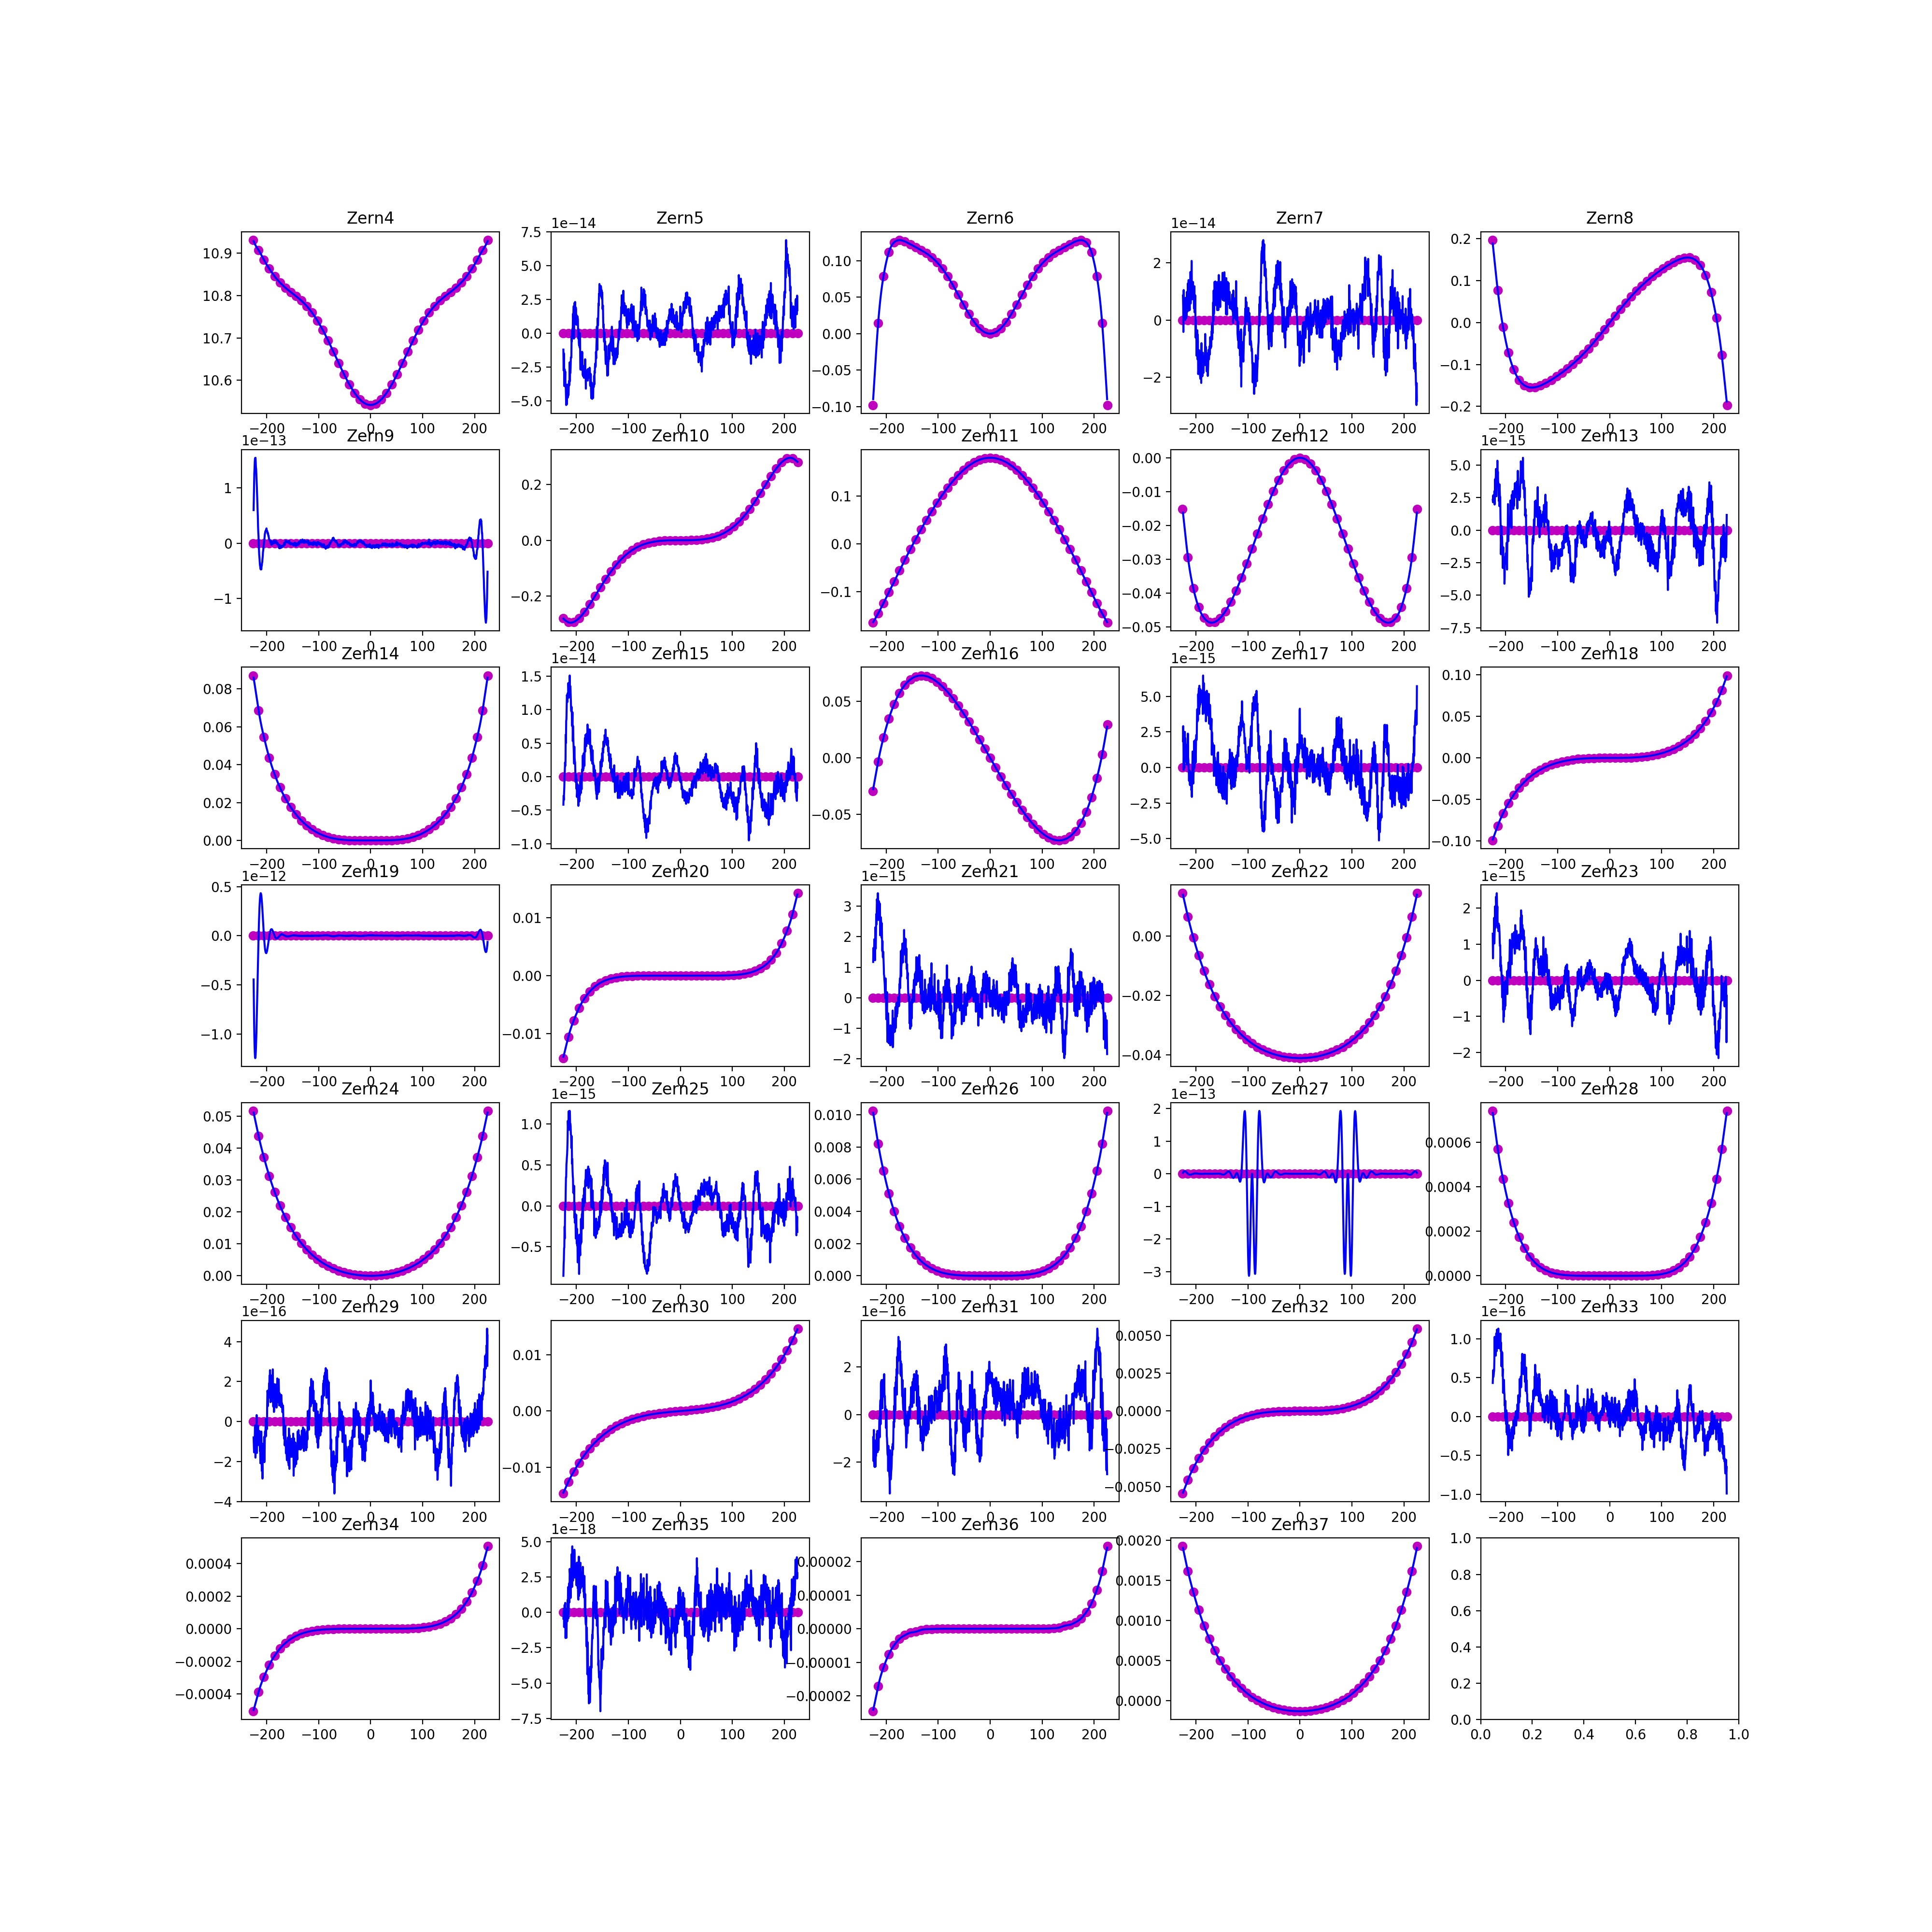

In [13]:
# compare Zernike maps
f,ax = plt.subplots(7,5,figsize=(20,20))
axf = ax.flatten()
aplots = []

xtry = np.linspace(-225.,225.,1000)
ytry = np.zeros(xtry.shape[0])

pick = np.abs(y_fpw)<1e-5
xvals = x_fpw[pick]
yvals = y_fpw[pick]


for iz in range(3,37):
    zern_interp = dictOfInterps[iz](xtry,ytry)
    zvals = zern_fpw[pick,iz]
    aplot = axf[iz-3].plot(xvals,zvals,'mo')
    aplot = axf[iz-3].plot(xtry,zern_interp,'b-')
    axf[iz-3].set_title("Zern%d" % (iz+1))

In [14]:
# save objects for interpolation
newoutdict = {}
newoutdict['x'] = x_fpw
newoutdict['y'] = y_fpw
newoutdict['zcoeff'] = zern_fpw

# Pickle dictionary using protocol 0.
pickle.dump(newoutdict, open('/Users/roodman/Astrophysics/Zemax/Decam/ZernikeMaps/decam-2012/decam_2012-nominalzernike-1.5mmextrafocal.pickle','wb'))

